In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2

# Import scikit-learn metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score

#Import dataset from Kaggle

In [ ]:
!pip install q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d 'akbariffianto/final-skin-disease'

Dataset URL: https://www.kaggle.com/datasets/akbariffianto/final-skin-disease
License(s): apache-2.0
100% 4.35G/4.35G [03:20<00:00, 24.6MB/s]
100% 4.35G/4.35G [03:20<00:00, 23.3MB/s]


In [ ]:
import zipfile

zip_file_path = 'final-skin-disease.zip'

extract_dir = 'dataset'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: dataset


#Data Wrangling

##Data Gathering

In [ ]:
data_path = "dataset"

class_name_mapping = {
    "1. Eczema 1677": "Kanker Kulit dan Lesi Akibat Sinar Matahari",
    "2. Melanoma 15.75k": "Melanoma (Kanker Kulit Berbahaya)",
    "3. Atopic Dermatitis - 1.25k": "Eksim Atopik (Dermatitis Atopik)",
    "4. Basal Cell Carcinoma (BCC) 3323": "Karsinoma Sel Basal",
    "5. Melanocytic Nevi (NV) - 7970": "Tahi Lalat (Nevus Melanositik)",
    "6. Benign Keratosis-like Lesions (BKL) 2624": "Lesi Keratosis Jinak",
    "7. Psoriasis pictures Lichen Planus and related diseases - 2k": "Psoriasis dan Penyakit Kulit Terkait",
    "8. Seborrheic Keratoses and other Benign Tumors - 1.8k": "Keratosis Seboroik dan Tumor Jinak Lainnya",
    "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k": "Infeksi Jamur (Kurap, Kandidiasis, dll.)",
    "10. Warts Molluscum and other Viral Infections - 2103": "Infeksi Virus (Kutil, Molluscum, dll.)"
}

new_data_path = "final_dataset"
os.makedirs(new_data_path, exist_ok=True)

for old_class_name in os.listdir(data_path):
    old_class_path = os.path.join(data_path, old_class_name)

    if not os.path.isdir(old_class_path):
        continue

    new_class_name = class_name_mapping.get(old_class_name, old_class_name)
    new_class_path = os.path.join(new_data_path, new_class_name)

    shutil.copytree(old_class_path, new_class_path)

print("Renaming classes completed successfully!")

Renaming classes completed successfully!


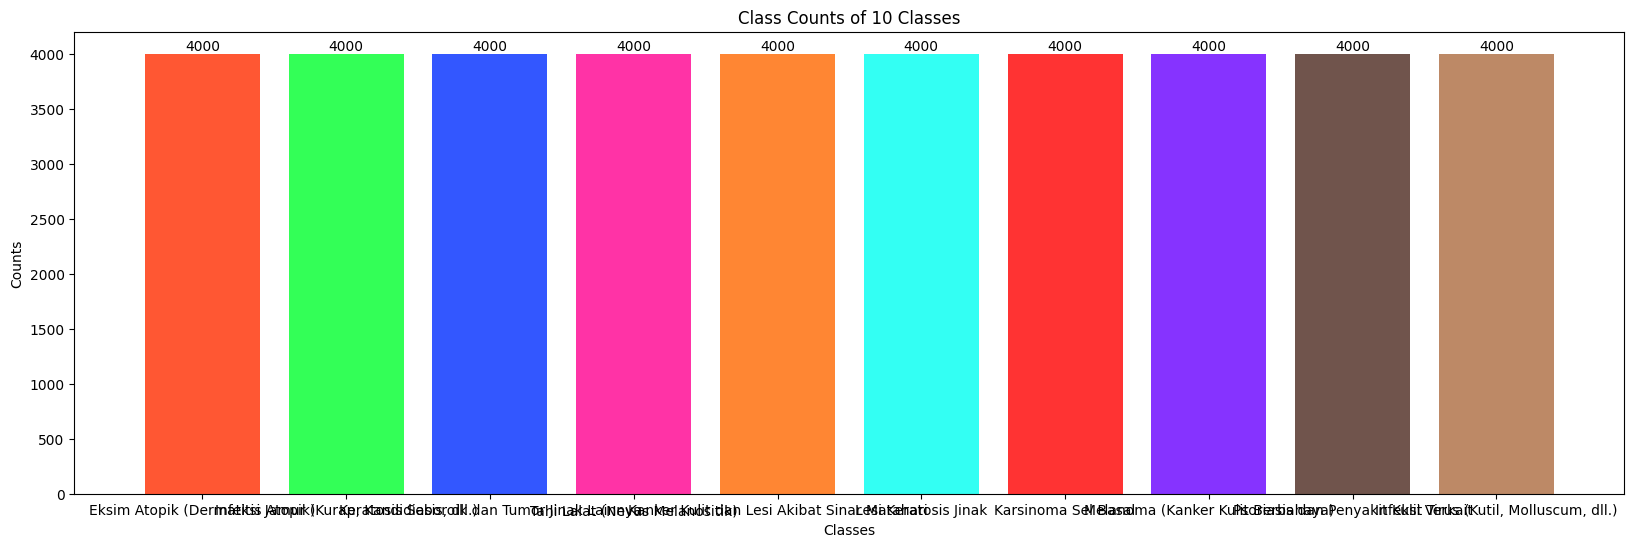

In [ ]:
data_path = 'final_dataset'
classes = os.listdir(data_path)
class_counts = [len(os.listdir(data_path + '/' + x)) for x in classes]
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color = ['#FF5733', '#33FF57', '#3357FF', '#FF33A6', '#FF8633', '#33FFF3', '#FF3333', '#8633FF', '#70544C', '#BD8966'])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 10 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )

#Splitting Dataset

In [ ]:
data_dir = "final_dataset"
batch_size = 32
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=128,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Same split proportion
    subset="validation",
    seed=128,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Step 2: Manually split out a 5% test set from the full dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

test_size = int(0.05 * len(full_dataset))  # 5% for test set
test_dataset = full_dataset.take(test_size)  # Take first 5% for testing
train_val_dataset = full_dataset.skip(test_size)  # The rest is for training+validation

Found 40000 files belonging to 10 classes.
Using 32000 files for training.
Found 40000 files belonging to 10 classes.
Using 8000 files for validation.
Found 40000 files belonging to 10 classes.


#Create Model

In [ ]:
#Load Resnet50
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

In [ ]:
FILL_MODE = 'nearest'

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

from tensorflow.keras.layers import Input

def create_model():
    model = Sequential()

    # Define the input shape explicitly
    model.add(Input(shape=(224, 224, 3)))

    model.add(data_augmentation)

    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model.add(base_model)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(10, activation='softmax'))

    return model

model = create_model()


Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,653,738 (90.23 MB)

 Trainable params: 8,997,290 (34.32 MB)

 Non-trainable params: 14,656,448 (55.91 MB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 224, 224, 3)
Output shape: (None, 10)


#Training Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[reduce_lr]
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 227s 215ms/step - accuracy: 0.1759 - loss: 2.2578 - val_accuracy: 0.1595 - val_loss: 3.4947 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 250s 203ms/step - accuracy: 0.2343 - loss: 1.8847 - val_accuracy: 0.1686 - val_loss: 2.5596 - learning_rate: 0.0010
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 271s 212ms/step - accuracy: 0.2608 - loss: 1.8188 - val_accuracy: 0.1408 - val_loss: 6.7158 - learning_rate: 0.0010
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 204s 204ms/step - accuracy: 0.2752 - loss: 1.7630 - val_accuracy: 0.2356 - val_loss: 2.0460 - learning_rate: 5.0000e-04
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 272s 215ms/step - accuracy: 0.2855 - loss: 1.7339 - val_accuracy: 0.1924 - val_loss: 2.2580 - learning_rate: 5.0000e-04
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 214s 214ms/step - accuracy: 0.2929 - loss: 1.7207 - val_accuracy: 0.2355 - val_loss: 2.2553 - learning_rate: 2.5000e-04
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

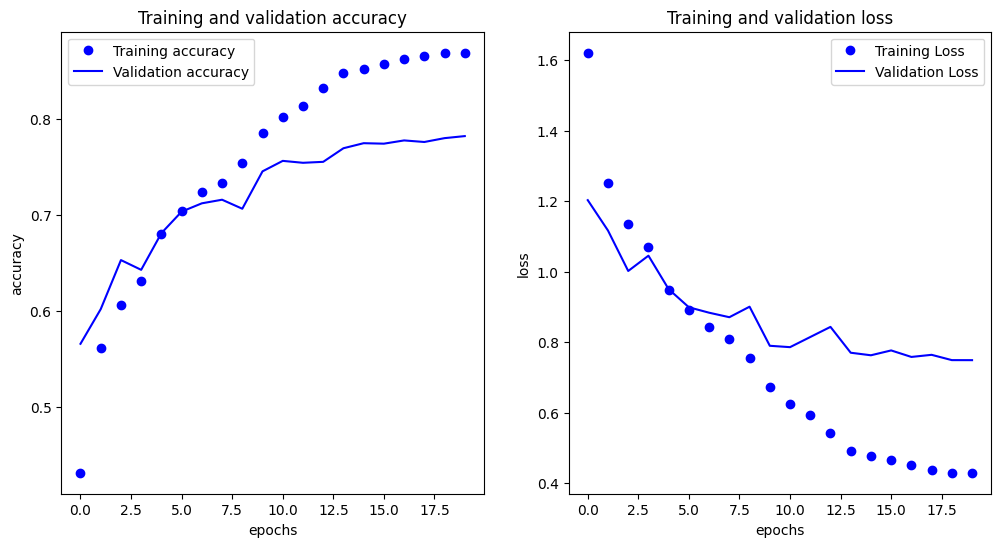

In [ ]:

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

#Evaluasi Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

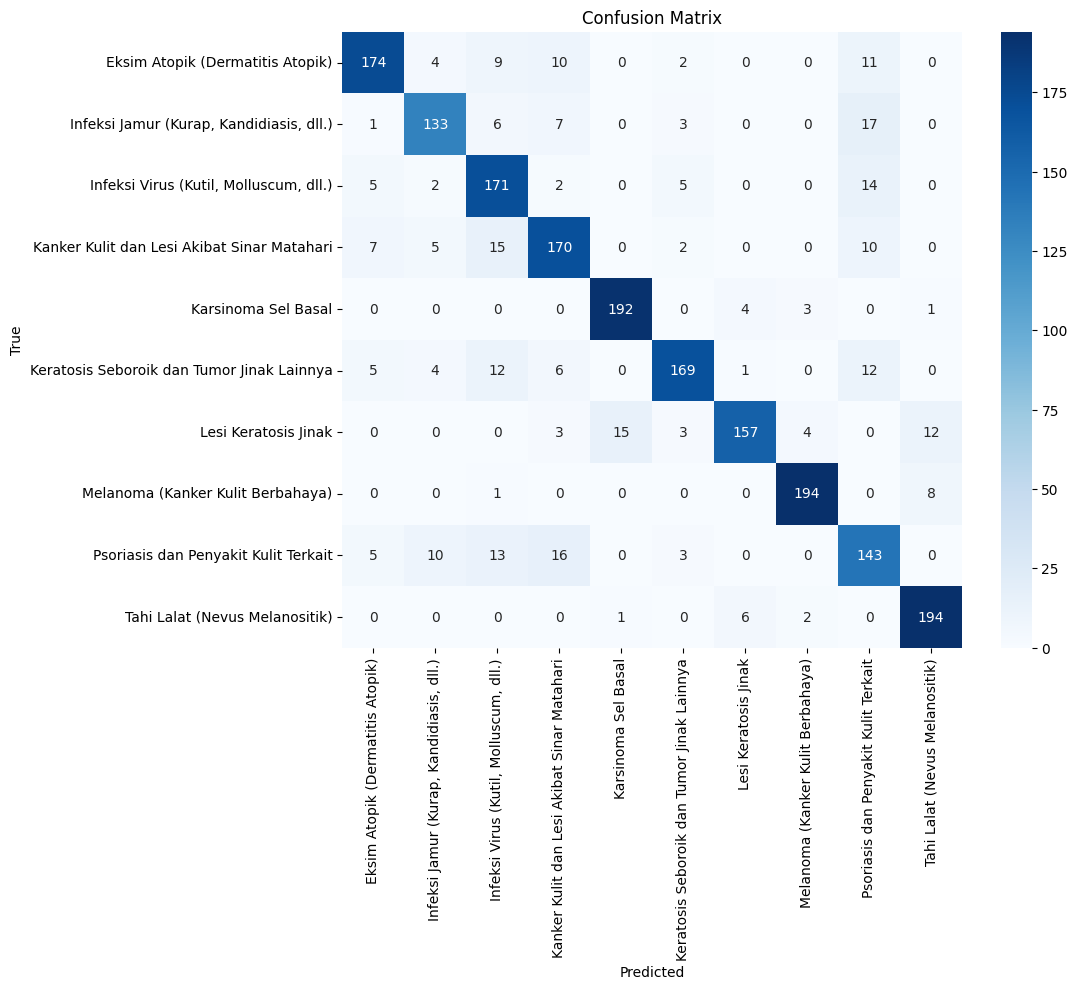

Weighted F1-Score: 0.8559473518213989

Classification Report:
                                             precision    recall  f1-score   support

           Eksim Atopik (Dermatitis Atopik)       0.88      0.83      0.86       210
   Infeksi Jamur (Kurap, Kandidiasis, dll.)       0.84      0.80      0.82       167
     Infeksi Virus (Kutil, Molluscum, dll.)       0.75      0.86      0.80       199
Kanker Kulit dan Lesi Akibat Sinar Matahari       0.79      0.81      0.80       209
                        Karsinoma Sel Basal       0.92      0.96      0.94       200
 Keratosis Seboroik dan Tumor Jinak Lainnya       0.90      0.81      0.85       209
                       Lesi Keratosis Jinak       0.93      0.81      0.87       194
          Melanoma (Kanker Kulit Berbahaya)       0.96      0.96      0.96       203
       Psoriasis dan Penyakit Kulit Terkait       0.69      0.75      0.72       190
             Tahi Lalat (Nevus Melanositik)       0.90      0.96      0.93       203

 

In [ ]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
classes = train_dataset.class_names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(y_true, y_pred, average='weighted')
print("Weighted F1-Score:", f1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

#Simpan Model

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights('model_86.weights.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('86_Skin_Disease.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp4ttgklnj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_577')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132493076698160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493076700272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493076694288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493658489600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493076704848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493076707136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493658498048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493658502800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493652057024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493652059488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132493658

In [ ]:
model.save('86_Skin Disease.keras')

print("Model saved successfully in Keras format!")

Model saved successfully in Keras format!


In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("86_Skin Disease.keras")
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,648,320 (158.88 MB)

 Trainable params: 8,997,290 (34.32 MB)

 Non-trainable params: 14,656,448 (55.91 MB)

 Optimizer params: 17,994,582 (68.64 MB)

None


In [ ]:
import os
os.makedirs("tfjs_model", exist_ok=True)

In [ ]:
!tensorflowjs_converter --input_format=keras 86_Skin Disease.keras tfjs_model

2024-12-05 14:40:06.109685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733409606.160765   35488 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733409606.167087   35488 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tfjs_layers_model,keras_keras,keras,tf_hub,tf_saved_model,keras_saved_model,tf_frozen_model}]
                                       [--output_format {tfjs_layers_model,tfjs_graph_model,keras_keras,keras,keras_saved_mo